In [7]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import torch
#import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
#from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
import albumentations as alb
from sklearn.model_selection import train_test_split
from random import randint
import cv2
import glob
from PIL import Image
from torchsummary import summary
import warnings
import torchvision.transforms as transforms
warnings.filterwarnings("ignore")

#import pandas as pd
#from torchvision.datasets import ImageFolder

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
PATH = '/kaggle/input/leapgestrecog/leapGestRecog/**/**/*.png'
IMG_SIZE = 256

In [73]:
images = glob.glob(PATH) # работает не попорядку
labels = [int(os.path.basename(i).split('_')[2])-1 for i in images]

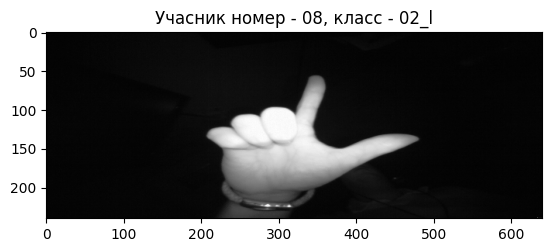

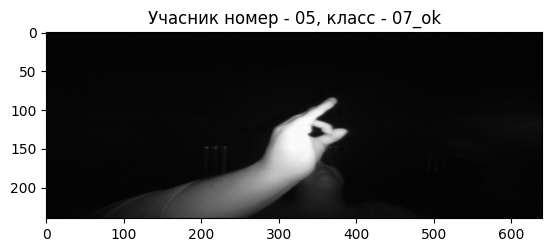

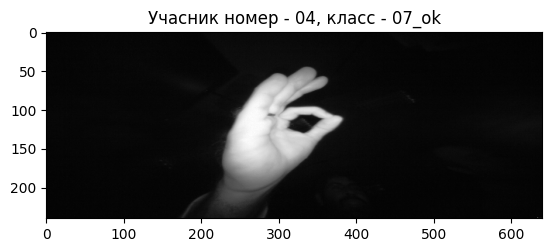

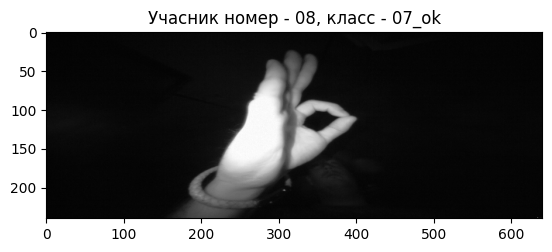

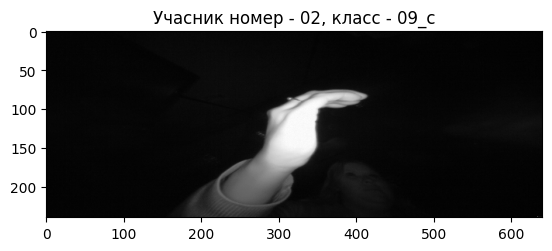

In [90]:
for i in range(0, 5):
    a = randint(0, 20000) # у нас 20 000
    Image.open(images[a])
    plt.imshow(np.array(Image.open(images[a])),cmap='gray') 
    text = images[a][42:].split('/')
    plt.title(f'Учасник номер - {text[0]}, класс - {text[1]}') 
    plt.show() 

## Подготовка датасета для прогрузки в Dataloader

In [188]:
class IMG_Dataset(Dataset):
    def __init__(self, images_filepaths,label, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform
        self.label = label

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #.COLOR_BGR2RGB) чб изображение
        if self.transform is not None:
            image = self.transform(image=(image))["image"]
            
        label = self.label[idx]
        return image, label


## Аргуменетация данных

In [135]:
from  albumentations.pytorch.transforms import ToTensorV2
from  albumentations.augmentations.geometric.rotate import Rotate 

In [282]:
alb_train_transform = alb.Compose([
     alb.Resize(70, 70),
     alb.ToGray(),
     alb.RandomBrightnessContrast(p=0.10, always_apply=False),
     alb.RandomCrop(height=64, width=64),
     Rotate(limit=20, interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False, always_apply=False, p=0.5),
     alb.OneOf([
                alb.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=1),
                alb.MotionBlur(p=1),  
                alb.GaussNoise(p=1)
               ]), 
    ToTensorV2() # только это работает !!!!! остальные выдают ошибку((
])
     
alb_test_transform = alb.Compose([
                   alb.Resize(64, 64),
                   alb.ToGray(),
                   ToTensorV2()
]) 

In [283]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.33, random_state=42)
train_dataset = IMG_Dataset(X_train, y_train, alb_train_transform)
test_dataset = IMG_Dataset(X_test, y_test, alb_test_transform)
batch_size = 256
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size)

torch.Size([1, 64, 64])


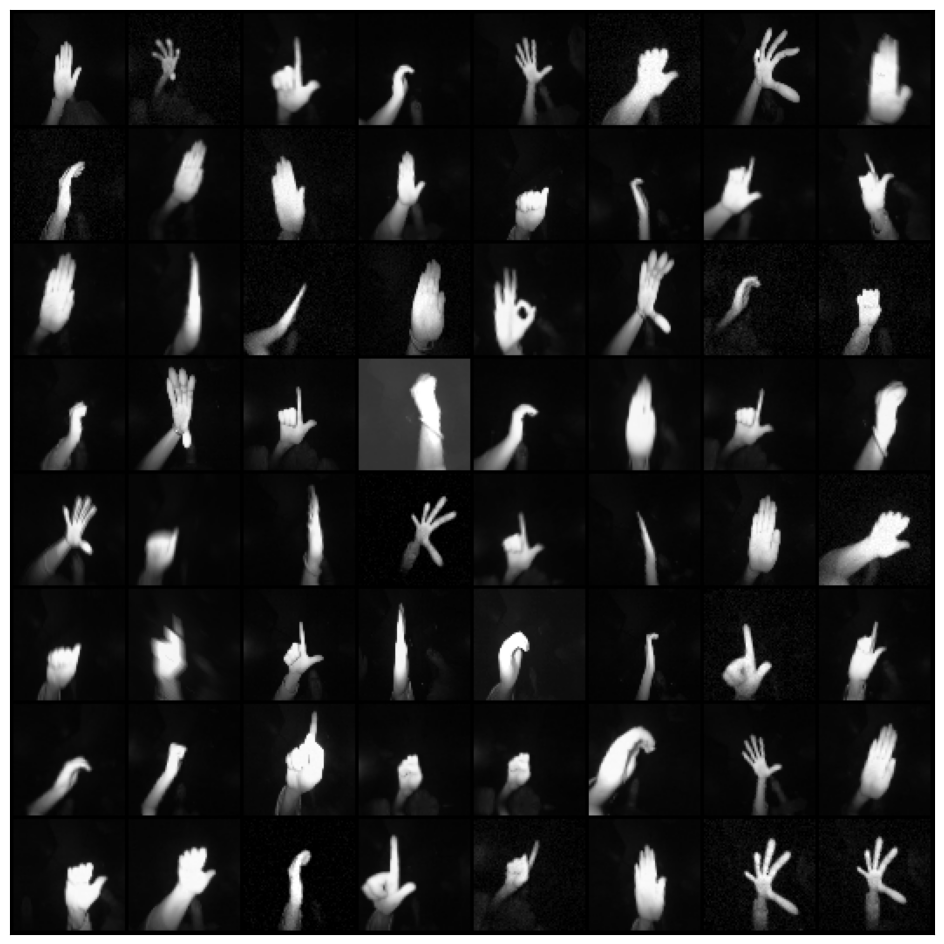

In [284]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(train_dl)

In [285]:
def flatten_sizer(w):
    """
    w-ширина и длина картинки
    возвращает размер изображения после сверток в сети CNN_Net_Arms
    только для квадратных картинок и CNN_Net_Arms
    """
    size_1 = (w - 2 - 2 - 2)//2
    size_2 = size_1//2
    size_2 = int(size_2)
    return size_2

class CNN_Net_Arms(nn.Module):
    def __init__(self, chanals=32, n_clases=10, size=6):
        super(CNN_Net_Arms, self).__init__()
        
        self.bn1 = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, chanals, 3) #32 in
        self.conv2 = nn.Conv2d(chanals, chanals, 3)
        self.conv3 = nn.Conv2d(chanals, chanals*2, 3)
        
        self.res1 = nn.Sequential(nn.Conv2d(chanals*2, chanals*2, 3, padding=1), nn.Conv2d(chanals*2, chanals*2, 3, padding=1))
        
        self.dropout1 = nn.Dropout2d(0.33)
        self.bn2 = nn.BatchNorm2d(chanals*2)
        
        
        self.conv4 = nn.Conv2d(chanals*2, chanals*2, 3, )#padding=1
        self.conv5 = nn.Conv2d(chanals*2, chanals*2, 3,)
        self.res2 =  nn.Sequential(nn.Conv2d(chanals*2, chanals*2, 3, padding=1), nn.Conv2d(chanals*2, chanals*2, 3, padding=1))
        
        self.dropout2 = nn.Dropout2d(0.33)
        self.bn3 = nn.BatchNorm2d(chanals*2)

        self.flatten = nn.Flatten() 
        self.fc1 = nn.Linear(size*size*chanals*2, 128)
        self.fc2 = nn.Linear(128, n_clases)

    def forward(self, ax):
        ax = ax.float()
        x = self.bn1(ax)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn2(x)
        #x = self.res1(x) + x
        x = self.dropout1(x)
        x = F.avg_pool2d(x, 2)
        
        x = torch.nn.functional.pad(x, (1, 1, 1, 1), mode='reflect')
        x = self.conv4(x)
        x = torch.nn.functional.pad(x, (1, 1, 1, 1), mode='reflect')
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.dropout2(x)
        #x = self.res2(x) + x
        x = self.bn3(x)
        
        x = F.avg_pool2d(x, 2)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
net = CNN_Net_Arms(size=flatten_sizer(64)).to(device)
summary(net, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 1, 64, 64]               2
            Conv2d-2           [-1, 32, 62, 62]             320
            Conv2d-3           [-1, 32, 60, 60]           9,248
            Conv2d-4           [-1, 64, 58, 58]          18,496
       BatchNorm2d-5           [-1, 64, 58, 58]             128
         Dropout2d-6           [-1, 64, 58, 58]               0
            Conv2d-7           [-1, 64, 29, 29]          36,928
            Conv2d-8           [-1, 64, 29, 29]          36,928
         Dropout2d-9           [-1, 64, 29, 29]               0
      BatchNorm2d-10           [-1, 64, 29, 29]             128
          Flatten-11                [-1, 12544]               0
           Linear-12                  [-1, 128]       1,605,760
           Linear-13                   [-1, 10]           1,290
Total params: 1,709,228
Trainable param

In [287]:
epochs = 40
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(net.parameters(), lr=lr) 
torch.cuda.empty_cache()

In [288]:
def train_net(model, epochs, optimizer, train_dl, test_dl):
    
    epoch_losses = []
    epoch_acc = []
    epoch_val_losses = []
    epoch_val_acc = []
    bundle = 20
    

    for epoch in range(epochs):  
        # loop over the dataset multiple times
        if (epoch // 10 ==0):
            for group in optimizer.param_groups:
                group['lr'] /= 2 # снижаем шаг в 2 раза каждые 5 этираций
        running_loss = 0.0
        cum_loss = []
        cum_acc = []

        # print(f'Epochs: {epoch+1}')
        time1 = time.time()
        model.train()
        for i, data in enumerate(train_dl, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            cum_loss.append(loss.item())

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            cum_acc.append(correct / total)

        time2 = time.time()
        epoch_losses.append(np.mean(cum_loss))
        epoch_acc.append(np.mean(cum_acc))

        cum_loss = []
        cum_acc = []
        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for i, data in enumerate(test_dl, 0):
                inputs, labels = data
                inputs = inputs.to(device) 
                labels = labels.to(device) 

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                cum_loss.append(loss.item())

                # Отслеживание точности
                total = labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct = (predicted == labels).sum().item()
                cum_acc.append(correct / total)

        epoch_val_losses.append(np.mean(cum_loss))
        epoch_val_acc.append(np.mean(cum_acc))
        print(f'Epochs: {epoch+1}   loss: {epoch_losses[-1]:.5f}   '
              f'accuracy: {epoch_acc[-1]*100:.3f}%   '
              f'loss_val: {epoch_val_losses[-1]:.5f}   '
              f'accuracy_val: {epoch_val_acc[-1]*100:.3f}%   '
              f'time = {time2-time1:.2f} s')
        
    return {'epoch_losses': epoch_losses, 
            'epoch_val_losses': epoch_val_losses, 
            'epoch_acc': epoch_acc, 
            'epoch_val_acc': epoch_val_acc}

history = train_net(net, epochs, optimizer, train_dl, test_dl)

Epochs: 1   loss: 1.83410   accuracy: 41.544%   loss_val: 0.79364   accuracy_val: 74.288%   time = 58.44 s
Epochs: 2   loss: 0.63088   accuracy: 79.708%   loss_val: 0.17011   accuracy_val: 94.923%   time = 59.62 s
Epochs: 3   loss: 0.30793   accuracy: 90.801%   loss_val: 0.25378   accuracy_val: 88.968%   time = 58.37 s
Epochs: 4   loss: 0.22007   accuracy: 93.639%   loss_val: 0.05381   accuracy_val: 99.661%   time = 57.98 s
Epochs: 5   loss: 0.17297   accuracy: 95.248%   loss_val: 0.03298   accuracy_val: 99.740%   time = 58.92 s
Epochs: 6   loss: 0.15947   accuracy: 95.661%   loss_val: 0.02969   accuracy_val: 99.740%   time = 58.10 s
Epochs: 7   loss: 0.15291   accuracy: 95.778%   loss_val: 0.02651   accuracy_val: 99.770%   time = 57.90 s
Epochs: 8   loss: 0.15115   accuracy: 95.942%   loss_val: 0.02607   accuracy_val: 99.770%   time = 59.24 s
Epochs: 9   loss: 0.13963   accuracy: 96.229%   loss_val: 0.02431   accuracy_val: 99.770%   time = 58.21 s
Epochs: 10   loss: 0.14552   accuracy

## Вывод


 Сеть на 10 эпо